# 11-BM (CMS) GIWAXS Plotting Notebook
**Time Series Diffraction**

Updated: 07/27/23

## Setup

### Kernel Package Installations
(Not needed if you have followed the process below under 'Environment Export')

In [2]:
### Kernel updates if needed, remember to restart kernel after running this cell!:
!pip install -e /nsls2/users/kwhite1/github_repositories/PyHyperScattering
!pip install tifftools # tifftools package for saving series image plots as tiff stacks

Obtaining file:///nsls2/users/kwhite1/github_repositories/PyHyperScattering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for PyHyperScattering (pyproject.toml) ... done
  Created wheel for PyHyperScattering: filename=PyHyperScattering-0+untagged.539.gefb043c.dirty-0.editable-py3-none-any.whl size=5529 sha256=77869096fc3ba6b1990567a9501fbee84fa3bb40aed8bb0095bb2db9dafacd23
  Stored in directory: /tmp/pip-ephem-wheel-cache-gxm05in9/wheels/30/84/5c/14c2ecfa0d45346e2aedbd65a4d8a149b1284612774dc76b95
Successfully built PyHyperScattering
  Attempting uninstall: PyHyperScattering
    Found existing installation: PyHyperScattering 0+untagged.539.gefb043c.dirty
    Uninstalling PyHyperScattering-0+untagged.539.gefb043c.dirty:
      Successfully uninstalled PyHyperScattering-0+untagged.539.gefb043c.dirty


### Virtual Environment Setup (optional)
If you'd rather save the output NSLS-II environment as a .yml file to avoid reloading the above
packages, you can follow the procedure below:

**(0)** Capture the output of pip freeze in your notebook. 

This will give you a list of your pip-installed packages, including those installed in editable mode. 

To capture this output in your notebook in generated 'pip_requirements.txt' and 'conda_requirements.txt' files, run:

In [1]:
import envgen

envgen.main('test')


Starting process to create new environment test...
Categorizing packages...
Getting list of installed packages...
Checking package aiofiles on PyPi...
Checking package aiohttp on PyPi...
Checking package alembic on PyPi...
Checking package amostra on PyPi...
Checking package ansiwrap on PyPi...
Checking package anyio on PyPi...
Checking package appdirs on PyPi...
Checking package arabic-reshaper on PyPi...
Checking package area-detector-handlers on PyPi...
Checking package argon2-cffi on PyPi...
Checking package argon2-cffi-bindings on PyPi...
Checking package arvpyf on PyPi...
Checking package asciitree on PyPi...
Checking package asdf on PyPi...
Checking package asdf-astropy on PyPi...
Checking package asdf-coordinates-schemas on PyPi...
Checking package asdf-standard on PyPi...
Checking package asdf-transform-schemas on PyPi...
Checking package asdf-unit-schemas on PyPi...
Checking package asdf-wcs-schemas on PyPi...
Checking package asn1crypto on PyPi...
Checking package asteval on

base.yml already exists. Overwrite? (y/n):  y


Creating new environment test from base.yml...
Solving environment: ...working... failed



ResolvePackageNotFound: 
  - bluesky-base==1.11.0=pyhd8ed1ab_0
  - bluesky==1.11.0=pyha770c72_0



Installing packages into test...


sh: 1: source: not found
sh: 1: source: not found


**(1)** Export your default environment (without pip packages) into a .yml file. You'll want to exclude the prefix and the pip dependencies for now. Change the name 'pyHyper' to what you want your environment to be.

Make sure you are in the current working directory you would like the .yml to be generated, then, enter the following into the terminal:

**(bash)**
```bash
conda env export --no-builds --name base | grep -v "^prefix: " | grep -v "pip:" > base.yml


**(2.0)** Skip this step unless steps 3.0 and 3.1 work.

**(2.1.1)** Add the pip packages to your pyHyper.yml file. 
You can add the pip requirements from pip_requirements.txt to your base_environment.yml 
file manually. Open pyHyper.yml in a text editor, and add the following lines at 
the end:

```
  - pip:
    - -r file:nsls2/users/kwhite1/github_repositories/giwaxs_suite_kw/GIXSCMS/pip_requirements.txt
```

**Make sure your 'pip_requirements.txt' file is in the same directory as your pyHyper.yml file.**

**Note:** Use the absolute path of the file on the machine you are installing the environment if you have issues with finding pip_requirements.txt during the installation. You will have to change the path between your local machine installation and NSLS-II JupyterHub.

**(3.0)** Create the new environment on your local machine and the NSLS-II JupyterHub. After transferring your pyHyper.yml and pip_requirements.txt files to your local machine and the remote node, you can create the new environment (let's call it pyHyper) with:

On the NSLS-II JupyterHub, move into the folder containing **base.yml**, **pip_requirements.txt**, & **conda_requirements.txt** then run the following in the terminal:

**(bash)**
```bash
conda env create -f base.yml -n pyHyper
```

**(3.1)** Install your packages from the command line using the following syntax, first, activate your environment:

**(bash)**
```bash
conda activate pyHyper
```

Second, install the pip requirements from pip_requirements.txt:

**(bash)**
```bash
!pip install -r pip_requirements.txt
```

Third, install the conda-forge requirements from conda_requirements.txt:

**(bash)**
```bash
!while read requirement; do conda install --yes $requirement; done < conda_requirements.txt
```

**Note**: In event the installation does not proceed properly, you can remove the environment from NSLS-II JupyterHub using the following: 

**(bash)**
```bash
conda env remove --name pyHyper

```

This will create a new Conda environment named myenv with the same packages as your default environment.

**(4)** Install new packages in editable mode. Navigate to your package directory using **ls** and **cd** and run the pip installations. Analogous to the **Kernel Package Installations** step above, you can run the following in the terminal:

**(bash)**
```bash
# pip install -e # this is the generalized form
pip install -e /nsls2/users/kwhite1/github_repositories/PyHyperScattering
pip install tifftools # tifftools package for saving series image plots as tiff stacks
```

**(5)** After installation, and for each session moving forward, make sure to activate your new environment using:

**(bash)**
```bash
conda activate pyHyper
```

### Module Imports

In [1]:
import pathlib, re, os, gc
import tifftools  # only needed if loading tiffs, requires installing into default ipykernel: !pip install tifftools
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import PyHyperScattering as phs
from tqdm.auto import tqdm  # progress bar loader!

# Define colormap:
cmap = plt.cm.turbo
cmap.set_bad('black')

# Print current PyHyperScattering Version
print(f'Using PyHyperScattering Version: {phs.__version__}')

/nsls2/users/kwhite1/github_repositories/PyHyperScattering/src/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator


Using PyHyperScattering Version: 0+untagged.539.gefb043c.dirty


### User Specific File Path Definitions

In [3]:
# Define your relevant paths here, you can use the ".exists()" method to make sure you defined a path correctly.
userPath = pathlib.Path('/nsls2/users/kwhite1')  # Your users path is great for small items that are personal to you (100 GB limit)
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')  # The proposals path is a good place to store large data (>1 TB space?)
dataPath = propPath.joinpath('2023C2_KWhite')
maskponiPath = userPath.joinpath('github_repositories/giwaxs_suite/ponimask_kwhite')
savePath = dataPath.joinpath('analysis')

# PONI File & Mask Filepaths
poniFile = maskponiPath.joinpath('jun23_poni_01_LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.poni')
maskFile = maskponiPath.joinpath('jun23_nslsii11bmcms_WAXS2pil1M_mask_02.edf')

# Zarr Series File Paths
raw_seriesPath = savePath.joinpath('raw_series_zarrs')
recip_seriesPath = savePath.joinpath('recip_series_zarrs')
caked_seriesPath = savePath.joinpath('caked_series_zarrs')

tiffPath = savePath.joinpath('tiff_stacks')
# -------------------------
# Originating Data Folders
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite2
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite3
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite4
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite5

# Proposal (Data) Folders
# /nsls2/data/cms/proposals/2023-2/pass-311415/
# /nsls2/data/cms/proposals/2023-2/pass-311415/2023C1_KWhite/
# /nsls2/data/cms/proposals/2023-2/pass-311415/2023C2_KWhite/
# /nsls2/data/cms/proposals/2023-1/pass-310206/

# Analysis Folders
# /nsls2/data/cms/proposals/2023-2/pass-311415/2023C2_KWhite/analysis/

# Repos
# /nsls2/users/kwhite1/github_repositories
# /nsls2/users/kwhite1/github_repositories/PyHyperScattering

In [5]:
# List the files inside a folder
sorted([f.name for f in seriesPath.glob('caked*pybtz*')])

['caked_1117893_pybtz_0to10s_qpara_011.zarr',
 'caked_1117894_pybtz_10to90s_qpara_011.zarr',
 'caked_1117895_pybtz_90to180s_qpara_011.zarr',
 'caked_1118200_pybtz_0to10s_qpara_013.zarr',
 'caked_1118201_pybtz_10to90s_qpara_013.zarr',
 'caked_1118202_pybtz_90to180s_qpara_013.zarr',
 'caked_1118329_pybtz_0to10s_qpara_014.zarr',
 'caked_1118330_pybtz_10to90s_qpara_014.zarr',
 'caked_1118331_pybtz_90to180s_qpara_014.zarr']

## Time-resolved GIWAXS Plotting

### Cartesian image stack processing

In [6]:
# Load zarr dataset(s):
filenames = sorted([f.name for f in seriesPath.glob('recip*pybtz*014*')])
DA_0to10 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[0])).DA
DA_10to90 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[1])).DA
DA_90to180 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[2])).DA

DA_0to10 = DA_0to10.where(DA_0to10>1e-8)
DA_10to90 = DA_10to90.where(DA_10to90>1e-8)
DA_90to180 = DA_90to180.where(DA_90to180>1e-8)

# Concatenate into one dataarray along time dimension if necessary
exposure_times = (0.095, 0.495, 1.995)
DA = xr.concat([(DA_0to10/exposure_times[0]), (DA_10to90/exposure_times[1]), (DA_90to180/exposure_times[2])], dim='time')
DA.attrs = DA_0to10.attrs
DA.attrs['exposure_time'] = exposure_times
DA

<xarray.DataArray 'DA' (time: 305, q_z: 1043, q_para: 981)>
dask.array<concatenate, shape=(305, 1043, 981), dtype=float32, chunksize=(20, 131, 246), chunktype=numpy.ndarray>
Coordinates:
  * q_para   (q_para) float64 -2.48 -2.475 -2.47 -2.466 ... 2.235 2.24 2.245
  * q_z      (q_z) float64 -1.889 -1.884 -1.88 -1.875 ... 2.963 2.968 2.972
  * time     (time) float64 0.1 0.2 0.3 0.4 0.5 ... 174.0 176.0 178.0 180.0
Attributes: (12/14)
    blade_speed:           40
    concentration:         15
    detector:              maxs.tiff
    exposure_time:         (0.095, 0.495, 1.995)
    gap_height:            200
    incident_angle:        th0.120
    ...                    ...
    scan_id:               1118329
    solution_temperature:  60
    solvent:               CBCNp5
    stage_temperature:     60
    time_start:            544.2s
    x_position_offset:     x0.000

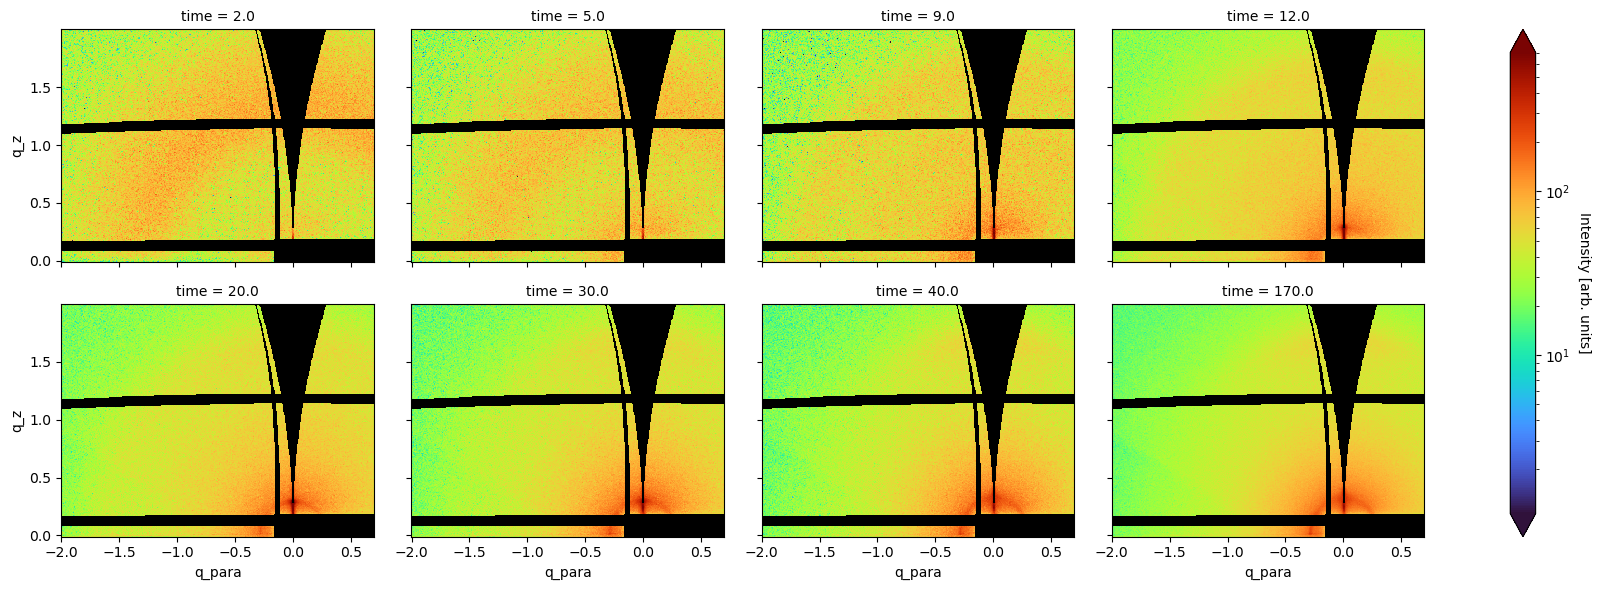

In [7]:
# Facet plot of selected times
cmin = float(DA.compute().quantile(1e-2))
cmax = float(DA.compute().quantile(1-1e-5))
times = [2, 5, 9, 12, 20, 30, 40, 170]

fg = DA.sel(q_para=slice(-2, 0.7), q_z=slice(-0.01, 2)).sel(time=times, method='nearest').plot.imshow(figsize=(18, 6),
                col='time', col_wrap=4, norm=LogNorm(cmin, cmax), cmap=cmap)
fg.cbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
for axes in fg.axs.flatten():
    axes.set(aspect='equal')

plt.show()

In [8]:
# ### Saves tiff images for all time slices
# sample = f'{DA.material}_{DA.solvent}_{DA.sample_number}'

# for time in tqdm(DA.time, desc='Making tiffs...'):
#     time = np.round(float(time), 1)
#     ax = DA.sel(time=time, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2, 0.7)).plot.imshow(figsize=(7,4), cmap=cmap, norm=LogNorm(cmin, cmax))
#     ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'PY-BTz BHJ in CB, 4% CN; Time = {time} s')
#     ax.figure.set_tight_layout(True)
#     # plt.show()
#     ax.figure.savefig(outPath.joinpath(f'single_tiffs/{sample}_time-{time}.tiff'), dpi=100)
#     plt.close('all')

In [9]:
# ### Stack tiff frames
# framePaths = sorted(outPath.joinpath('single_tiffs').glob(f'{sample}*'), key=lambda x: float(str(x).split('-')[-1][:-5]))
# frame1 = tifftools.read_tiff(framePaths[0])
# for framePath in tqdm(framePaths[1:], desc='Stacking tiffs...'):
#     frame = tifftools.read_tiff(framePath)
#     frame1['ifds'].extend(frame['ifds'])
# tifftools.write_tiff(frame1, outPath.joinpath(f'tiff_stacks/recip_{sample}_ExpTimeNormed.tiff'), allowExisting=True)

### Polar image stack processing

In [10]:
# Load zarr dataset(s):
filenames = sorted([f.name for f in seriesPath.glob('caked*pybtz*014*')])
DA_0to10 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[0])).DA
DA_10to90 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[1])).DA
DA_90to180 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[2])).DA

DA_0to10 = DA_0to10.where(DA_0to10>1e-8)
DA_10to90 = DA_10to90.where(DA_10to90>1e-8)
DA_90to180 = DA_90to180.where(DA_90to180>1e-8)

# Concatenate into one dataarray along time dimension
exposure_times = (0.095, 0.495, 1.995)
DA = xr.concat([(DA_0to10/exposure_times[0]), (DA_10to90/exposure_times[1]), (DA_90to180/exposure_times[2])], dim='time')
DA.attrs = DA_0to10.attrs
DA.attrs['exposure_time'] = exposure_times

# Add a dictionary so I stop forgetting to change plot titles for CN percent:
percent_dict = {'CB':0, 'CBCNp1':1, 'CBCNp5':4}

# Optionally remove first few time slices:
# for my PY-BTz samples: 
tzero_dict = {'CB':0, 'CBCNp1':0.7, 'CBCNp5':1.2}
tzero = tzero_dict[DA.solvent]
DA = DA.sel(time=slice(tzero, 400))
DA['time'] = np.round(DA['time'] - (tzero-0.1), 1)
DA

<xarray.DataArray 'DA' (time: 294, chi: 180, qr: 1000)>
dask.array<getitem, shape=(294, 180, 1000), dtype=float32, chunksize=(25, 45, 250), chunktype=numpy.ndarray>
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.1695 0.173 0.1766 0.1801 ... 3.714 3.718 3.721 3.725
  * time     (time) float64 0.1 0.2 0.3 0.4 0.5 ... 172.9 174.9 176.9 178.9
Attributes: (12/15)
    blade_speed:           40
    concentration:         15
    detector:              maxs.tiff
    exposure_time:         (0.095, 0.495, 1.995)
    gap_height:            200
    incident_angle:        th0.120
    ...                    ...
    scan_id:               1118329
    solution_temperature:  60
    solvent:               CBCNp5
    stage_temperature:     60
    time_start:            544.2s
    x_position_offset:     x0.000

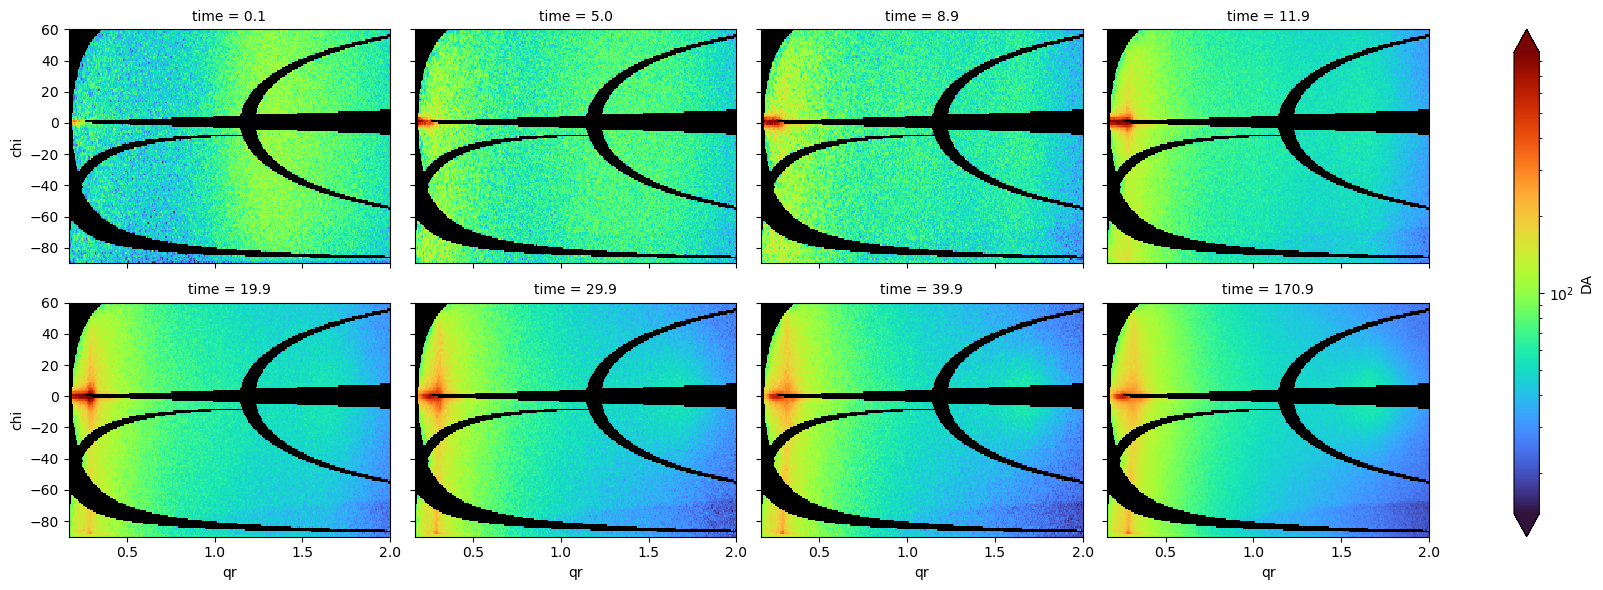

In [11]:
# Facet plot of selected times, mostly to check clims and that nothing weird is happening
cmin = float(DA.compute().quantile(1e-2))
cmax = float(DA.compute().quantile(1-1e-5))
times = [0, 5, 9, 12, 20, 30, 40, 170]

axs = DA.sel(time=times, method='nearest').sel(chi=slice(-90, 60), qr=slice(0,2)).plot.imshow(figsize=(18,6), col='time', col_wrap=4, norm=LogNorm(cmin, cmax), cmap=cmap)
plt.show()
plt.close('all')

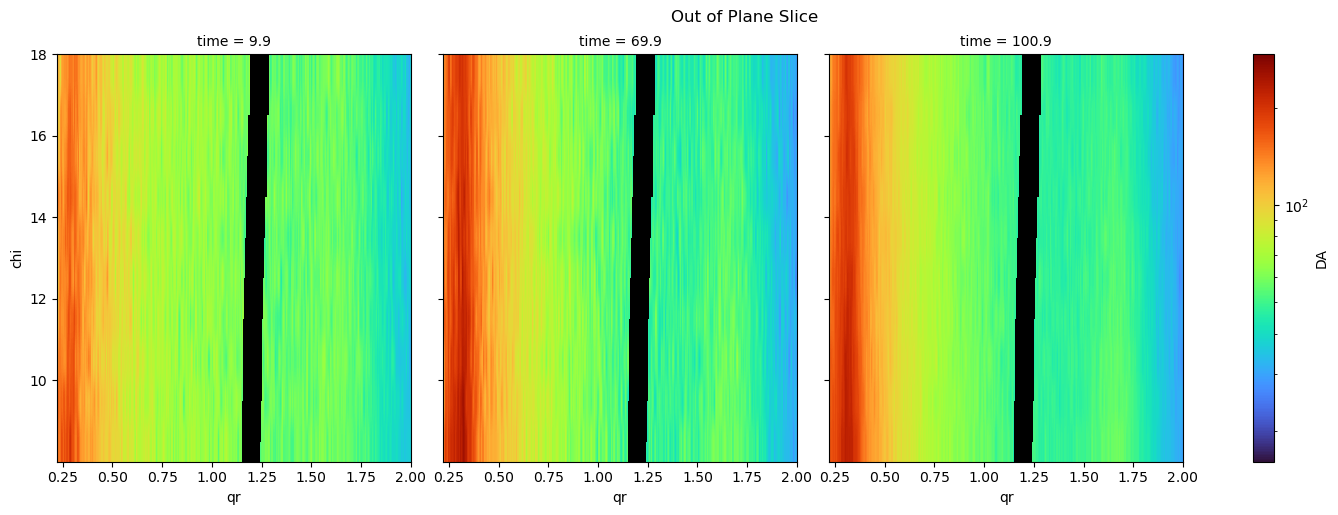

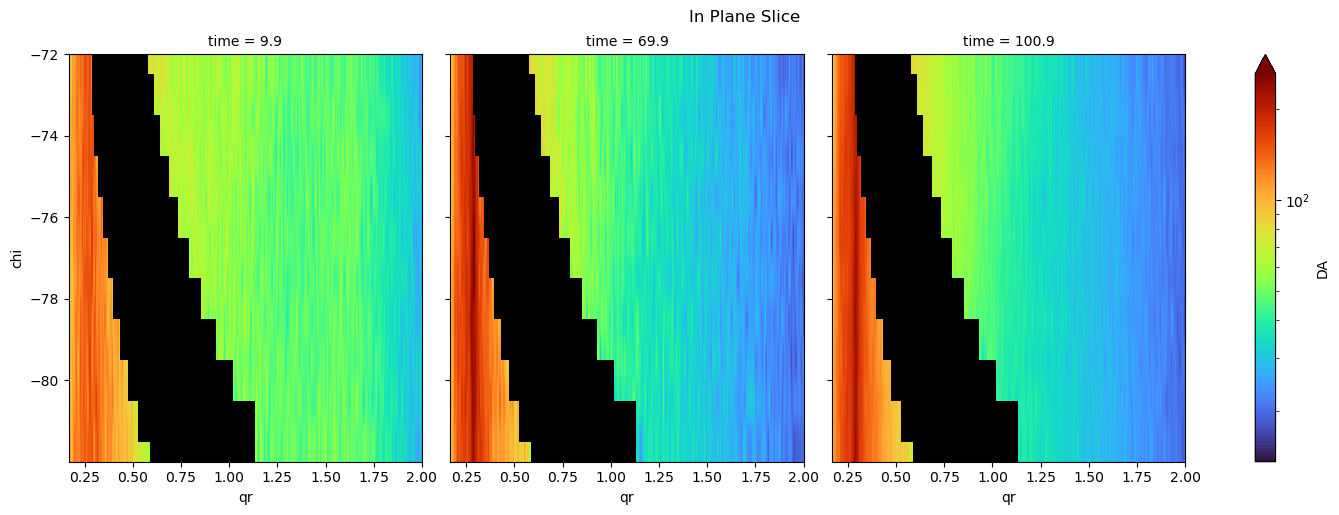

In [12]:
# Select chi regions, zoom into plot to check positions of detector gaps / edges / misc
OOP_chi_min = 8
OOP_chi_max = 18

IP_chi_min = -82
IP_chi_max = -72

OOP_DA = DA.sel(chi=slice(OOP_chi_min, OOP_chi_max))
OOP_cmin = float(OOP_DA.compute().quantile(1e-2))
OOP_cmax = float(OOP_DA.compute().quantile(1-1e-5))

IP_DA = DA.sel(chi=slice(IP_chi_min, IP_chi_max))
IP_cmin = float(IP_DA.compute().quantile(1e-2))
IP_cmax = float(IP_DA.compute().quantile(1-1e-5))

axs = OOP_DA.sel(time=[10, 70, 100], method='nearest').sel(qr=slice(0.22,2)).plot.imshow(figsize=(15,5),
        col='time', cmap=cmap, norm=LogNorm(OOP_cmin, OOP_cmax), interpolation='antialiased')
axs.fig.suptitle('Out of Plane Slice', y=1.02)

axs = IP_DA.sel(time=[10, 70, 100], method='nearest').sel(qr=slice(0,2)).plot.imshow(figsize=(15,5),
        col='time', cmap=cmap, norm=LogNorm(IP_cmin, IP_cmax), interpolation='antialiased')
axs.fig.suptitle('In Plane Slice', y=1.02)

plt.show()

In [13]:
# Interpolate detector gaps along a chosen dimension 
plt.close('all')
method='linear'
dim='chi'
interp_DA = DA.compute().interpolate_na(dim=dim, method=method)

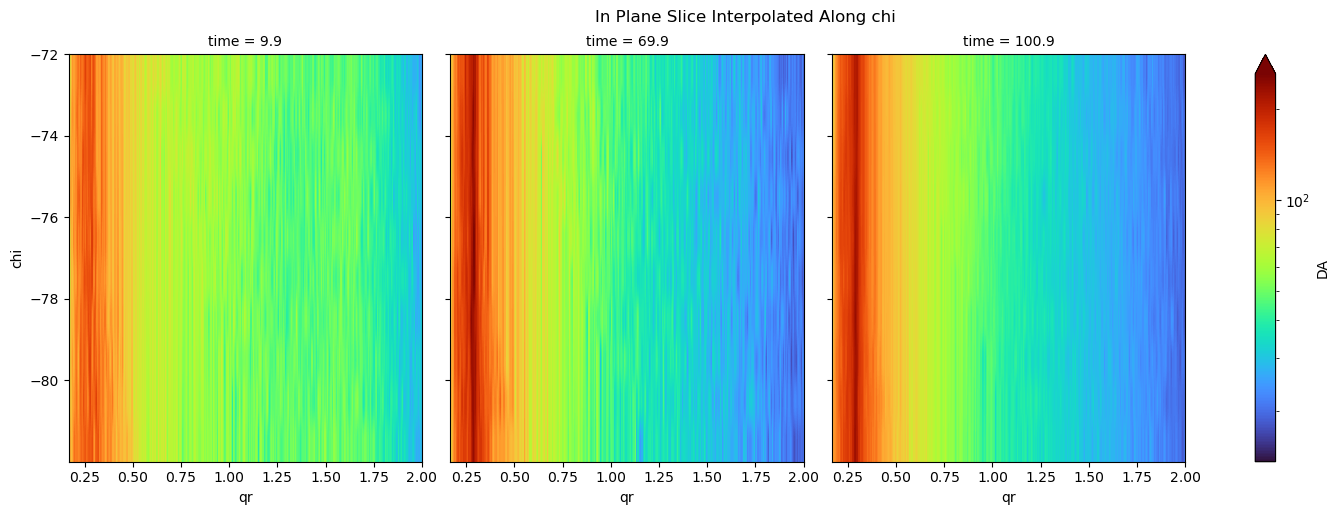

In [14]:
# Plot interpolated region, only necessary when detector gap is not easily to be avoided
# As seen above, that is only the case for my in my in plane region:
interp_IP_DA = interp_DA.sel(chi=slice(IP_chi_min, IP_chi_max))

axs = interp_IP_DA.sel(time=[10, 70, 100], method='nearest').sel(qr=slice(0,2)).plot.imshow(figsize=(15,5),
        col='time', cmap=cmap, norm=LogNorm(IP_cmin, IP_cmax), interpolation='antialiased')
axs.fig.suptitle(f'In Plane Slice Interpolated Along {dim}', y=1.02)

plt.show()
plt.close('all')

In [15]:
# # Choose and save OOP & IP dataarrays as .csv's if desired
# OOP_DA.sum('chi').to_pandas().to_csv(outPath.joinpath('tr_OOP-IP', f'{DA.material}-{DA.solvent}_{DA.sample_number}_OOP.csv'))
# interp_IP_DA.sum('chi').to_pandas().to_csv(outPath.joinpath('tr_OOP-IP', f'{DA.material}-{DA.solvent}_{DA.sample_number}_IP.csv'))

#### Time resolved in plane & out of plane linecuts plotting

  0%|          | 0/141 [00:00<?, ?it/s]

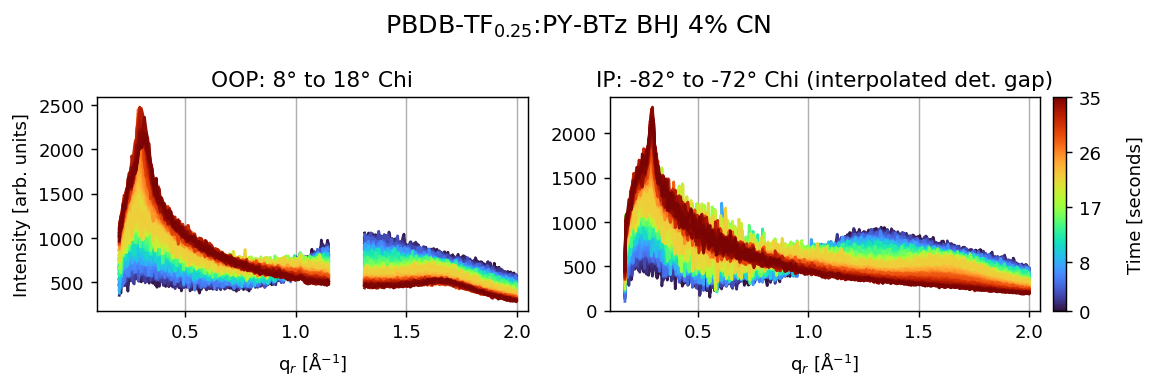

In [16]:
# Plot
time_slice = slice(0,35)

colors = cmap(np.linspace(0,1,len(DA.sel(time=time_slice).time)))
fig, axs = plt.subplots(1, 2, figsize=(9,3))

for i, time in enumerate(tqdm(DA.sel(time=time_slice).time)):
    # DA.sel(time=time, method='nearest').sel(chi=slice(7, 20), qr=slice(0.2,1.8)).sum('chi').plot.line(ax=axs[0], color=colors[i])
    OOP_DA.sum('chi').sel(time=time, method='nearest').sel(qr=slice(0.2,1.15)).plot.line(ax=axs[0], color=colors[i])
    OOP_DA.sum('chi').sel(time=time, method='nearest').sel(qr=slice(1.31,2)).plot.line(ax=axs[0], color=colors[i])
    interp_IP_DA.sum('chi').sel(time=time, method='nearest').sel(qr=slice(0,2)).plot.line(ax=axs[1], color=colors[i])
    
# Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=time_slice.start, vmax=time_slice.stop))
cax = axs[1].inset_axes([1.03, 0, 0.03, 1])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(label=f'Time [seconds]', labelpad=14)
cbar.set_ticks(np.linspace(time_slice.start, time_slice.stop, 5).astype('int'))

# More plot customization
fig.suptitle('PBDB-TF$_{0.25}$:PY-BTz BHJ ' + f'{percent_dict[DA.solvent]}% CN', fontsize=14)
axs[0].set(xlim=(0.1, 2.05), title=f'OOP: {OOP_chi_min}° to {OOP_chi_max}° Chi', ylabel= 'Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
axs[0].grid(visible=True, which='major', axis='x')
axs[1].set(xlim=(0.1, 2.05), title=f'IP: {IP_chi_min}° to {IP_chi_max}° Chi (interpolated det. gap)', ylabel='', xlabel='q$_r$ [Å$^{-1}$]')
axs[1].grid(visible=True, which='major', axis='x')

fig.set(tight_layout=True, dpi=130)

# fig.savefig(outPath.joinpath('trGIWAXS_OOP-IP', f'{DA.material}_{DA.solvent}_{DA.sample_number}_{time_slice.start}to{time_slice.stop}s_linecuts.png'), dpi=150)

plt.show()
plt.close('all')

#### Time resolved in plane & out of plane 2D plotting

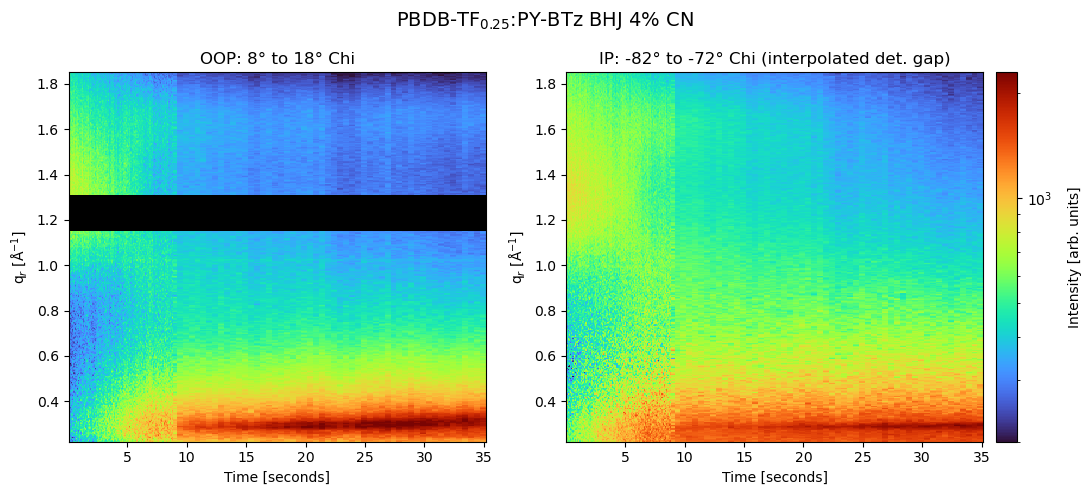

In [17]:
# Slice/sum data as needed for IP & OOP DataArrays
tr_OOP_DA = OOP_DA.sel(qr=slice(0.22,1.85), time=time_slice).sum('chi')
tr_OOP_DA = tr_OOP_DA.where((tr_OOP_DA.qr<1.15) | (tr_OOP_DA.qr>1.31))
tr_IP_DA = interp_IP_DA.sel(qr=slice(0.22,1.85), time=time_slice).sum('chi')

fig, axs = plt.subplots(1, 2, figsize=(11,5))

tr_OOP_DA.plot(ax=axs[0], x='time', cmap=cmap, norm=LogNorm(3.7e2, 2.3e3), add_colorbar=False)
tr_IP_DA.plot(ax=axs[1], x='time', cmap=cmap, norm=LogNorm(2e2, 2.3e3), add_colorbar=False)

# Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(2e2, 2.3e3))
cax = axs[1].inset_axes([1.03, 0, 0.05, 1])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(label='Intensity [arb. units]', labelpad=12)

fig.suptitle('PBDB-TF$_{0.25}$:PY-BTz BHJ ' + f'{percent_dict[DA.solvent]}% CN', fontsize=14)
fig.set(tight_layout=True)

axs[0].set(title=f'OOP: {OOP_chi_min}° to {OOP_chi_max}° Chi', ylabel='q$_r$ [Å$^{-1}$]', xlabel='Time [seconds]')
axs[1].set(title=f'IP: {IP_chi_min}° to {IP_chi_max}° Chi (interpolated det. gap)', ylabel='q$_r$ [Å$^{-1}$]', xlabel='Time [seconds]')

# fig.savefig(outPath.joinpath('trGIWAXS_OOP-IP', f'{DA.material}_{DA.solvent}_{DA.sample_number}_{time_slice.start}to{time_slice.stop}s_2D-plot.png'), dpi=150)

plt.show()
plt.close('all')